In [1]:
%load_ext autoreload
%autoreload 2

from datetime import datetime, timedelta
from CandleStream import CandleStream 
import train
import pandas as pd
import dataset
import strategy
import transform
import utils
from indicators import Indicators
import strategy
import financetrainer
from calender_utils import *

c:\Users\Wizcom\Documents\personal\trading\trading_env\Lib\site-packages\pandas_ta\__init__.py:7: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


In [2]:
stream = CandleStream()

[I 250811 11:56:11 smartConnect:121] in pool


In [ ]:

exchange = 'NSE'
start_date = datetime(2024, 1, 1, 9, 10)
end_date = datetime(2025, 1, 1, 3, 30)
# symbol = 'TCS'
# token = 11536
interval = "15min"
tradetype = 'sell'
entrycol = 'close'
atr_sl_multiplier = 1
risk = 1
bestrr = 2
lookbackweek = 10

decision_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 10,],
    'min_samples_split': [10],
    'min_samples_leaf': [ 10, 20, 30],
}

randomforestparams = {
    'n_estimators': [150],               # More trees can improve stability
    'max_depth': [5, 10],                   # Deeper trees for complex patterns
    'min_samples_split': [10, 20],               # Controls tree growth
    'min_samples_leaf': [10, 20, 30],              # Prevents overfitting on small splits
    # 'max_features': ['sqrt', 'log2', None],        # Feature selection per split
    # 'bootstrap': [True, False],                    # Whether to use bootstrapping
}

xgb_clf_params = {
    'n_estimators': [100, 200],
    'max_depth': [6, 10],
    # 'learning_rate': [0.01, 0.1, 0.2],
    # 'subsample': [0.6, 0.8, 1.0],
    # 'colsample_bytree': [0.6, 0.8, 1.0],
    'scale_pos_weight': [1, 2, 5]  # useful for imbalanced datasets
}


In [ ]:
dflist = []
for symbol in pd.read_csv("ind_nifty500list.csv")['Symbol'][::1]:
    token = utils.get_token(exchange, symbol + '-EQ')
    print(symbol)
    if token is not None:
        print(symbol, token)
        try :
            df = dataset.get_data(stream, exchange, symbol, token, start_date, end_date, interval)
            mystrategy = strategy.strategy15MinPreviousDay(df, tradetype, 1)
            df = mystrategy.run()
            df = df[df['istrade']]
            df.reset_index(inplace=True, drop = True)
            dflist.append(df)
        except Exception as e:
            print("\033[91m[Error] :", e, "\033[0m")


In [ ]:
import numpy as np
df = pd.concat(dflist)
df = df.sort_values(by='timestamp')
df = df.dropna()
df.reset_index(inplace=True, drop = True)
df['label'] = np.where(df['rr'] > bestrr, True, False)

df = df[df['select']]
df.reset_index(inplace=True, drop = True)
features = ['ema_11', 'ema_30', 'ema_50', 'ema_100', 'supertrend_10_3', 'supertrend_10_2', 'supertrend_8_3', 'supertrend_15_1', 'vwap', 'rsi_14', 'bb_upper_20_2', 'macd_12_26_9', 'adx_14', 'previous_day_close']

for col in features:
    if col != 'atr':
        df[col] = round((df[col] - df['close'])/df['close'] * 100 , 1)
    else:
        df[col] = round(df[col]/df['close'] * 100 , 2)

# if tradetype == 'sell': 
#     df['select'] = (df['close']) 
# else:
    # df['select'] = (df['close'] > df['ema_11']) & (df['low'] < df['ema_11'])

len(df[df['rr'] > 2])/len(df), len(df)

In [ ]:
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.utils import shuffle

label = ['label']
balance = 1
risk = 1
reportlist = []

def mymatric(y_test, y_pred):
    if isinstance(y_test, pd.Series):
        y_test = y_test.to_frame(name='label')
    elif 'label' not in y_test.columns:
        y_test = y_test.rename(columns={y_test.columns[0]: 'label'})
    y_test['pred'] = y_pred.astype(bool)
    # y_test['pred'] = y_pred
    # print(y_test)
    y_test = y_test[y_test['pred']]
    favoourtrade = y_test[y_test['label']]
    print(f"Accuracy of my system : {round(len(favoourtrade)/len(y_test)*100,2)} % in trade :{len(y_test)}")

def report_builder(y_test, y_pred):
    global balance
    y_test = y_test.values.ravel()
    for i in range(len(y_pred)):
        actual = y_test[i]
        predicted = y_pred[i]
        if predicted:
            if actual:
                balance = balance + bestrr * risk
            else:
                balance = balance - risk
            reportlist.append(balance)    

        
dates = get_training_dates(end_date.date(), start_date.date(),frequency="weekly")
for i in range(10,len(dates[:50])-1):
    traindates = [ dates[i-lookbackweek], dates[i]]
    testdates = [dates[i], dates[i+1]]
    df_train =  utils.filter_data_by_dates(df.copy(), traindates[0], traindates[1])
    df_test =  utils.filter_data_by_dates(df.copy(), testdates[0], testdates[1])
    train.run(df_train, df_test, features, label, xgb_clf_params)

In [ ]:
reportlist

In [ ]:
import matplotlib.pyplot as plt
plt.plot(reportlist)

In [ ]:

exchange = 'NSE'
start_date = datetime(2024, 10, 1, 9, 10)
end_date = datetime(2025, 8, 12, 9, 10)
interval = "10min"
bookrr = 2
all_results = []
is_live = False
save_image = False

while(True):
    for symbol in pd.read_csv('ind_nifty200list.csv')['Symbol']:
        try:
            token = utils.get_token(exchange, symbol + '-EQ')
            orgdf = dataset.get_data(stream, 'NSE', symbol, token, start_date, end_date, interval)
            mystrategy = strategy.EMA_8_21_50_100_Aligned_by_Ayushi(orgdf.copy(), 'buy', window = 3, ema_list = [8, 21, 50, 100], symbol = symbol, save_trade = save_image, live = is_live)
            results = mystrategy.run()
            all_results.extend(results)
            mystrategy = strategy.EMA_8_21_50_100_Aligned_by_Ayushi(orgdf.copy(), 'sell', window = 3, ema_list = [8, 21, 50, 100], symbol = symbol, save_trade = save_image, live = is_live)
            results = mystrategy.run()
            all_results.extend(results)
            # break
        except Exception as e:
            print('Error : ', e)
    if is_live == False:
        break

In [142]:
df = pd.DataFrame(all_results)
# df = df[df['entry']< df['previous_day_high']]
columns = ['previous_day_low',	'previous_day_open', 'previous_day_close',	'previous_day_high']
for col in columns:
    df[col] = round((df['entry'] - df[col])/df['entry']*100, 2)
df['goodtrade'] = np.where(df['goodtrade'] > 1.5, 1.5, -1)

In [143]:
len(df[df['goodtrade']>=1.5])/len(df)

0.5567428150331614

In [ ]:
df['goodtrade'].sum(), len(df)

In [ ]:
len(df[df['previous_day_open']>df['entry']]), len(df[df['previous_day_open']>df['entry']])

In [ ]:
import numpy as np
import pandas as pd

def analyse(orgdf):
    results = []

    for i in range(-10, 10):
        dftmp = orgdf.copy()
        dftmp = dftmp[dftmp[['previous_day_close', 'previous_day_close']].min(axis=1) < i].copy()

        for rr in np.arange(1, 4, 0.5):
            rr_values = np.where(dftmp['goodtrade'] > rr, rr, -1)
            acc = round(np.sum(rr_values >= rr) / len(rr_values), 2)
            profit = round(np.sum(rr_values), 2)
            alltrades = len(rr_values)

            results.append({
                'Threshold': i,
                'RR': rr,
                'Accuracy': acc,
                'Profit': profit,
                'Trades': alltrades
            })

    return pd.DataFrame(results)

import matplotlib.pyplot as plt
import seaborn as sns

results_df = analyse(df)

# Accuracy Plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=results_df, x='Threshold', y='Accuracy', hue='RR', marker='o')
plt.title('Accuracy vs Threshold for Different RR')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.show()

# Profit Plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=results_df, x='Threshold', y='Profit', hue='RR', marker='o')
plt.title('Net Profit vs Threshold for Different RR')
plt.ylabel('Profit')
plt.grid(True)
plt.show()

# Trades Plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=results_df, x='Threshold', y='Trades', hue='RR', marker='o')
plt.title('Total Trades vs Threshold for Different RR')
plt.ylabel('Number of Trades')
plt.grid(True)
plt.show()

        

In [ ]:
df

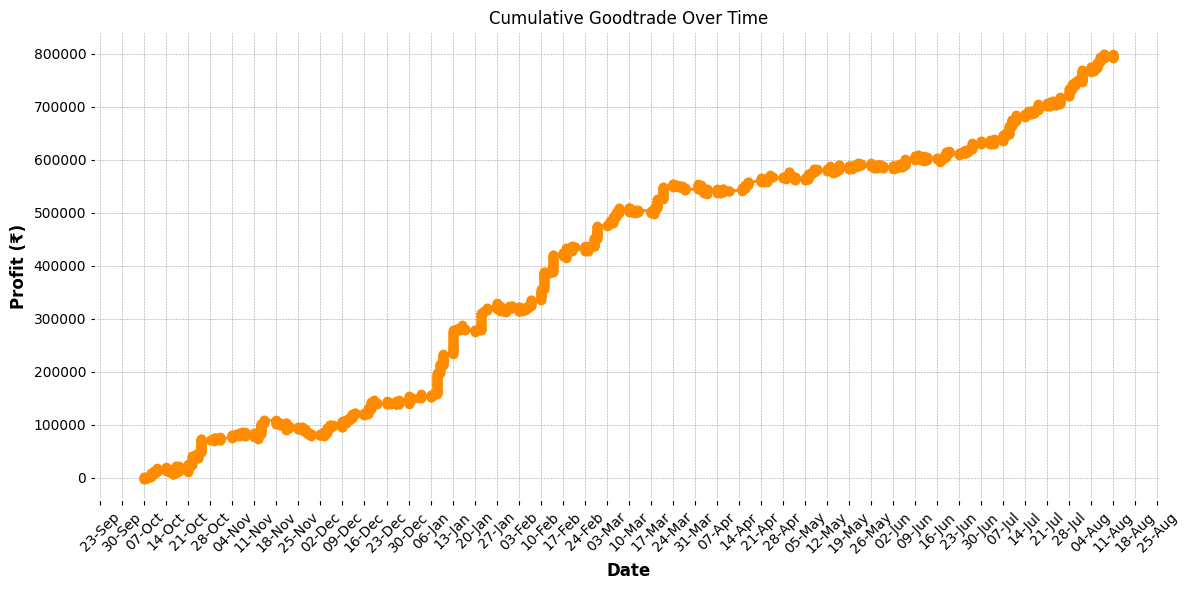

In [164]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

risk = 1000
df = pd.DataFrame(all_results)

# Calculate percentage differences
columns = ['previous_day_low', 'previous_day_open', 'previous_day_close', 'previous_day_high']
for col in columns:
    df[col] = round((df['entry'] - df[col]) / df['entry'] * 100, 2)

# Cap goodtrade values
df['goodtrade'] = np.where(df['goodtrade'] > 1.5, 1.5, -1)

# Prepare date and sort
df['day'] = pd.to_datetime(df['tradetime']).dt.date
df = df.sort_values(by='tradetime').reset_index(drop=True)

# Calculate cumulative goodtrade
df['tax'] = risk * 0.1
df['goodtrade'] = df['goodtrade'] * risk - df['tax']
df['goodtrade'] = df['goodtrade'].cumsum()

# Convert 'day' to datetime for plotting
df['day'] = pd.to_datetime(df['day'])

# Plot with weekday locator
plt.figure(figsize=(12, 6))
plt.plot(df['day'], df['goodtrade'], marker='o', color='darkorange')
plt.title('Cumulative Goodtrade Over Time')
plt.xlabel('Date')
plt.ylabel('Profit (₹)')

# Format x-axis: show ticks only on Mondays
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO, interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))

plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
df['goodtrade'].plot()

In [ ]:
df['goodtrade']

In [ ]:
df